In [1]:
import json
import requests
import json
import matplotlib
import re
import pydot
from graphviz import Digraph
from graphviz import Source
from inference_utils import Utils
import networkx as nx
from networkx.readwrite import json_graph

In [17]:
from enum import Enum

class EdgeStatus(Enum):
    wiktdata_error = 1
    double_edge_error = 2
    single_zero_success = 3
    no_edge_success = 4
    neutral = 5
    edge_not_found = 6
    node_not_found = 7
    zero_noedge_both_success = 8 

def append_wikidata(graph, triplet, rule):
    curr_edges = [
        (n1, n2, d['color']) for n1, n2, d in graph.edges(data=True)]

    if triplet['arg1'] is "novalue" or triplet['arg2'] is "novalue" or triplet['arg3'] is "novalue":
        return EdgeStatus.wiktdata_error
    
    a = nx.get_node_attributes(graph,'str_name')
    
    for n in a:
        if a[n] == triplet['arg2']:
            nulledgecount = 0
            edgetoit = False
            for e in curr_edges:
                #megy e bele el
                if e[1] == n:
                    edgetoit = True
                    
                if e[0] == n:
                    #ketts el vizsgalata
                    for c in curr_edges:
                        if c[0] == e[1] and c[1] == n:
                            return EdgeStatus.double_edge_error
                        
                if rule == 0:
                    if e[2] == 0:
                        nulledgecount+=1
                        if triplet['arg3'] not in a:
                            graph.add_node(triplet['arg3']+'_', str_name=triplet['arg3'], expanded=True)
                            graph.add_edge(triplet['arg3']+'_', e[1], color=0)
                            
                if rule == 2:
                    if e[2] == 2:
                        nulledgecount+=1
                        if triplet['arg3'] not in a:
                            graph.add_node(triplet['arg3']+'_', str_name=triplet['arg3'], expanded=True)
                            graph.add_edge(triplet['arg1']+'_', e[1], color=0)

            if nulledgecount == 0:
                return EdgeStatus.edge_not_found
            if nulledgecount == 1 and edgetoit == True:
                return EdgeStatus.single_zero_success
            if edgetoit == False and nulledgecount != 1:
                return EdgeStatus.no_edge_success
            if nulledgecount == 1 and edgetoit == False:
                return EdgeStatus.zero_noedge_both_success
            
            return EdgeStatus.neutral

    return EdgeStatus.node_not_found

In [26]:
triplets = {}
graphs = {}
statuses = {}
count = 0
with open("togetherfiltered.json", "r+") as f:
    for l in f:
        line = eval(l)
        predicate = line['arg2']
        data = {'word':   predicate}
        data_json = json.dumps(data)
        payload = {'json_payload': data_json}
        headers = {'Content-type': 'application/json', 'Accept': 'text/plain'}

        r = requests.post("http://127.0.0.1:5000/wikidata", data=data_json, headers=headers)
        
        word_graph = r.json()['word']
        g_word_graph = json_graph.adjacency.adjacency_graph(word_graph)
        
        status = append_wikidata(g_word_graph, line, 2)
        
        triplets[count] = (line['arg1'], line['arg2'], line['arg3'])
        graphs[count] = g_word_graph
        statuses[count] = status
        count+=1

In [32]:
alg_success = [k for k in statuses.values() if k in [EdgeStatus(8)]]
len(alg_success)

128

In [126]:
utils = Utils()
g_dot = utils.to_dot(graphs[23])
print(g_dot)

digraph finite_state_machine {
	dpi=100;
	association_football_player_ [shape = circle, label = "association_football_player"];
	job_139629397255440 [shape = circle, label = "job"];
	occupation_139629397254224 [shape = circle, label = "occupation"];
	profession_139629406289552 [shape = circle, label = "profession"];
	association_football_player_ -> job_139629397255440 [ label = "0" ];
	association_football_player_ -> profession_139629406289552 [ label = "0" ];
	occupation_139629397254224 -> job_139629397255440 [ label = "0" ];
	occupation_139629397254224 -> profession_139629406289552 [ label = "0" ];
}


In [127]:
v_g = Source(g_dot)

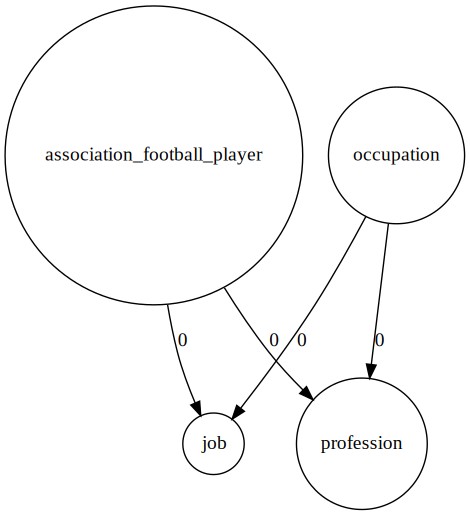

In [128]:
v_g

In [13]:
dict_predicates = {}
with open('/home/adaamko/wikidata/wikidata_all_with_labels_filtered', 'r') as f:
    count = 0
    for line in f:
        d = eval(line)
        if d['arg2'] not in dict_predicates:
            dict_predicates[d['arg2']] = 0
        else:
            dict_predicates[d['arg2']] += 1

In [19]:
len(dict_predicates)

195

In [21]:
import statistics

In [33]:
m = statistics.mean(dict_predicates.values())

In [37]:
statistics.pstdev(dict_predicates.values(), m)

566557.0731679171

In [30]:
dict_predicates.keys()

['radix',
 'protocol',
 'producer',
 'armament',
 'destroyed',
 'results',
 'totem',
 'shape',
 'via',
 'including',
 'rector',
 'defender',
 'codomain',
 'captain',
 'continent',
 'occupation',
 'candidate',
 'winner',
 'father',
 'employer',
 'penalty',
 'platform',
 'charge',
 'location',
 'endianness',
 'notation',
 'plaintiff',
 'allegiance',
 'replaces',
 'occupant',
 'judge',
 'GPU',
 'depicts',
 'investor',
 'vice-county',
 'ammunition',
 'solves',
 'B-side',
 'follows',
 'professorship',
 'curator',
 'presenter',
 'addressee',
 'victory',
 'cleavage',
 'relation',
 'vessel',
 'domain',
 'translator',
 'choreographer',
 'creator',
 'series',
 'authority',
 'relative',
 'culture',
 'antiparticle',
 'stepparent',
 'sponsor',
 'distributor',
 'cathedral',
 'programmer',
 'sport',
 'constellation',
 'enclosure',
 'ploidy',
 'anthem',
 'basionym',
 'habitat',
 'CPU',
 'religion',
 'ambitus',
 'co-driver',
 'capital',
 'developer',
 'movement',
 'wears',
 'overlies',
 'of',
 'host',


In [40]:
dict_predicates_filter_novalue = {}
with open('/home/adaamko/wikidata/wikidata_all_with_labels_filtered', 'r') as f:
    count = 0
    for line in f:
        d = eval(line)
        if d['arg1'] is "novalue" or d['arg2'] is "novalue" or d['arg3'] is "novalue":
            continue
        if d['arg2'] not in dict_predicates_filter_novalue:
            dict_predicates_filter_novalue[d['arg2']] = 0
        else:
            dict_predicates_filter_novalue[d['arg2']] += 1

In [43]:
dict_predicates_filter_novalue.values()

[33,
 16,
 64462,
 2796,
 0,
 0,
 7,
 241,
 34,
 14,
 391,
 9,
 34,
 88,
 26853,
 2977193,
 5329,
 40133,
 86377,
 166436,
 358,
 43071,
 36,
 321564,
 26,
 64,
 20,
 3490,
 5849,
 10365,
 29,
 8,
 114853,
 122,
 20,
 1671,
 21,
 50,
 247240,
 61,
 55,
 2722,
 68,
 1376,
 59,
 3,
 371,
 36,
 781,
 228,
 170630,
 41996,
 100,
 8021,
 1044,
 60,
 190,
 57747,
 37864,
 1364,
 114,
 575081,
 10099,
 15,
 2,
 587,
 3422,
 25,
 592,
 44421,
 11,
 27,
 28043,
 23185,
 18762,
 45,
 149,
 104,
 6,
 121,
 711,
 422840,
 48,
 36221,
 15506,
 133,
 532,
 9692,
 31929,
 14452,
 50,
 776,
 102,
 6060,
 396,
 14,
 994,
 162,
 7380,
 95872,
 7864,
 1242,
 1956,
 67,
 70211,
 57681,
 28627,
 0,
 7349,
 10492,
 211,
 29,
 52534,
 5640,
 733,
 31,
 2863,
 3477,
 22,
 109,
 2,
 36,
 292,
 363,
 61435,
 556,
 479170,
 12,
 545,
 964,
 1325,
 112968,
 5317,
 222,
 96,
 5119,
 2045,
 194,
 4936,
 2340,
 251,
 15749,
 6,
 2695704,
 380,
 9,
 10789,
 2231,
 293,
 185640,
 1739,
 6,
 250,
 299,
 12,
 152893,
 5

In [44]:
dict_sentences = {}
with open('/home/adaamko/wikidata/wikidata_all_with_labels_filtered', 'r') as f:
    count = 0
    for line in f:
        d = eval(line)
        if d['arg1'] is "novalue" or d['arg2'] is "novalue" or d['arg3'] is "novalue":
            continue
        if d['arg2'] not in dict_sentences:
            dict_sentences[d['arg2']] = d

In [46]:
dict_sentences.keys()

['radix',
 'protocol',
 'producer',
 'armament',
 'destroyed',
 'results',
 'totem',
 'shape',
 'via',
 'including',
 'rector',
 'defender',
 'codomain',
 'captain',
 'continent',
 'occupation',
 'candidate',
 'winner',
 'father',
 'employer',
 'penalty',
 'platform',
 'charge',
 'location',
 'endianness',
 'notation',
 'plaintiff',
 'allegiance',
 'replaces',
 'occupant',
 'judge',
 'GPU',
 'depicts',
 'investor',
 'vice-county',
 'ammunition',
 'solves',
 'B-side',
 'follows',
 'professorship',
 'curator',
 'presenter',
 'addressee',
 'victory',
 'cleavage',
 'relation',
 'vessel',
 'domain',
 'translator',
 'choreographer',
 'creator',
 'series',
 'authority',
 'relative',
 'culture',
 'antiparticle',
 'stepparent',
 'sponsor',
 'distributor',
 'cathedral',
 'programmer',
 'sport',
 'constellation',
 'enclosure',
 'ploidy',
 'anthem',
 'basionym',
 'habitat',
 'CPU',
 'religion',
 'ambitus',
 'co-driver',
 'capital',
 'developer',
 'movement',
 'wears',
 'overlies',
 'of',
 'host',
